# Fitting SDSS ellipse galaxy

LRayleighJ 230401

## 下载数据
下载SDSS DR16数据的教程[链接](https://www.sdss4.org/dr16/tutorials/getimage/)

具体而言，根据指示进入[SDSS navigate tool](https://skyserver.sdss.org/dr16/en/tools/chart/navi.aspx), 在左边的文本框中输入ra和dec查询相应星系。example: NGC7597,ra=349.62597,dec=18.68925
![SDSSfield](./fig_SDSS/SDSSimage.png)

找到之后点击右下角Explore, 或者直接戳[这里](https://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?)进入Explore tool根据ra&dec查找也行。从左边栏找到FITS，进入后是下载`.fits`文件的链接。`Corrected Frames`是我们需要的图像，u,g,r,i,z是不同的波段
![SDSSfield](./fig_SDSS/SDSSfits.png)

需要注意的是下载的`.fits`文件中的视场是包含该星系的一整块SDSS Frame，如下图所示。所以还需要手动把需要的星系那一块给切出来。
![SDSSfield](./fig_SDSS/SDSSfield.png)

下面可视化一下`.fits`文件，绿色标记是NGC7597

(1489, 2048)


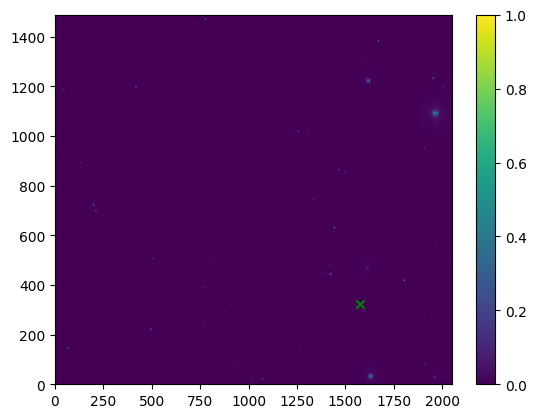

In [15]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

from scipy.optimize import leastsq
from ellipse_fit import fitting as eft

filename_image = "./data/correctframe/frame-i-006366-4-0132.fits"
hdul = fits.open(filename_image)
fitdata = hdul[0].data
print(fitdata.shape)

plt.figure()
plt.pcolormesh(fitdata)
plt.scatter([2048-472],[1489-1164],marker="x",c="green",label="NGC7597")
plt.colorbar()
plt.show()

## 流程

在NGC7597中心附近切了100x100 pixel的图片

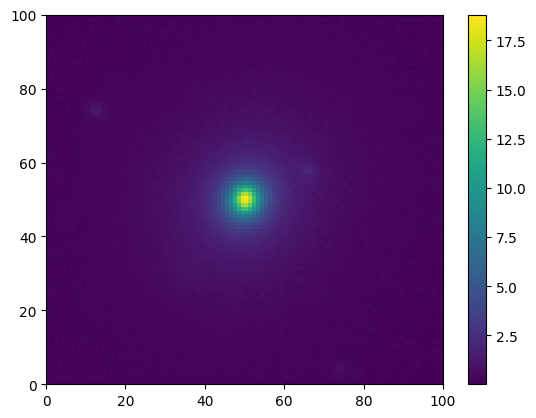

In [20]:
# NGC7597 349.62597 18.68925

# decide which band to use and define the center and size you want to cut.
bandlist = ["g","i","r","u","z"] # use i band
halfwidth_cut = 50
center_cut = (472, 1614)

# load data
filename_image = "./data/correctframe/frame-i-006366-4-0132.fits"
hdul = fits.open(filename_image)
fitdata = hdul[0].data

# SDSS field center: (472, 1614)
fitdata_cut = fitdata[center_cut[0]-halfwidth_cut:center_cut[0]+halfwidth_cut,center_cut[1]-halfwidth_cut:center_cut[1]+halfwidth_cut]
plt.figure()
plt.pcolormesh(fitdata_cut)
plt.colorbar()
plt.show()

算法的基本思路是，先统计整幅图全部pixel的luminosity的分布，然后将luminosity分bin,统计落到每个bin里的pixel，理想状态下这些点应该构成一个椭圆（就是等高线图的那个原理）。然后拟合椭圆的离心率和倾斜角。

拟合算法的基本思路是，利用椭圆上的点到两个焦点的距离的和为一个定值，模型的参数是半长轴的长度和两个焦点的坐标，损失函数是所有点到两个焦点的距离之和的方差。理想状态下找到最优解之后方差的极小值是0。

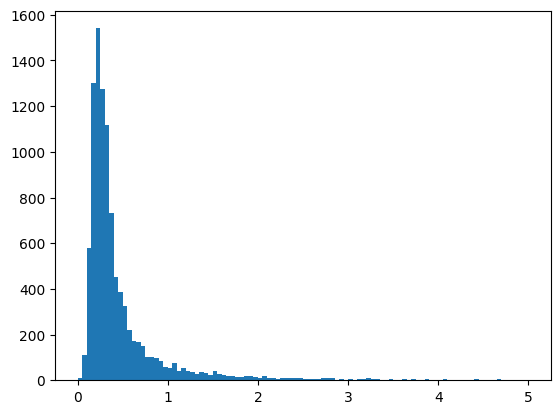

Not success
fitting failed at lumi=1.25


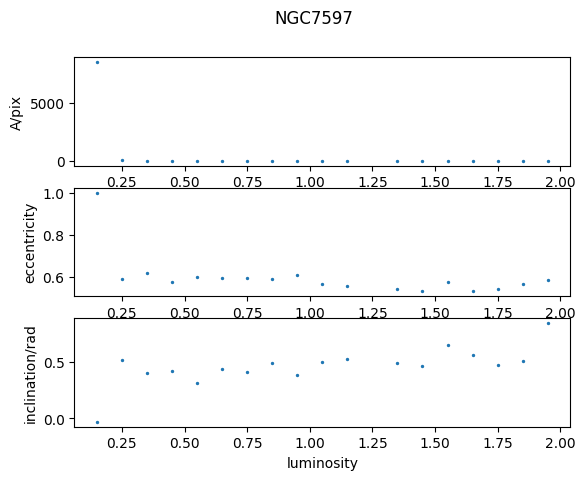

eccentricity and inclination(deg):  0.5982723180168213 26.59996354413405


In [21]:
flatfitdata = fitdata_cut.flatten()

plt.figure()
plt.hist(flatfitdata,bins=100,range=[0.,5.])
plt.show()
# plt.savefig("./figs/luminosity_distribution.pdf")

lumi_border_list = np.linspace(0.1,2,20)
lumi_center_list = np.linspace(0.15,1.95,19)

ecc_list = []
alpha_list = []
A_list = []
B_list = []
lumi_list = []

for lumi_index in range(len(lumi_center_list)):
    try:
        x_samples, y_samples = eft.get_contour_index(lumi_border_list[lumi_index], lumi_border_list[lumi_index+1], fitdata_cut)
        ellipse_center = np.array([np.mean(x_samples),np.mean(y_samples)])
        # Normalize
        x_samples = x_samples-np.mean(x_samples)
        y_samples = y_samples-np.mean(y_samples)

        # fit

        a_res, b_res, alpha_res = eft.fit_ellipse(x_samples, y_samples,init_params=(-10,-2,10,2,15)) #plot_axis=ax,xyadd=ellipse_center,  long axis, short axis, inclination of the main axis (radius, not degree)

        ecc = np.sqrt(1-b_res**2/a_res**2)
        ecc_list.append(ecc)
        alpha_list.append(alpha_res)
        A_list.append(a_res)
        B_list.append(b_res)
        lumi_list.append(lumi_center_list[lumi_index])
    except:
        print("fitting failed at lumi=%.2f"%lumi_center_list[lumi_index])
        continue


# test the static values
plt.figure()
plt.subplot(311)
plt.scatter(lumi_list,A_list,s=2)
plt.ylabel("A/pix")
plt.subplot(312)
plt.scatter(lumi_list,ecc_list,s=2)
plt.ylabel("eccentricity")
plt.subplot(313)
plt.scatter(lumi_list,alpha_list,s=2)
plt.xlabel("luminosity")
plt.ylabel("inclination/rad")
plt.suptitle("NGC7597")
plt.show()
# plt.savefig("test_regression.pdf")
# plt.close()

print("eccentricity and inclination(deg): ",np.mean(ecc_list),np.mean(alpha_list)*180/np.pi)

拟合sersic函数。上面我们回归出来有用的是倾角和离心率，椭圆中心确定为星系的中心。拟合光度L和半长轴A之间的sersic函数。具体方法是将A分bin，统计落到不同A bin中的点，计算L的平均值，以A bin中心值作为对应的A值。得到L(A)关系之后拟合就完事了。拟合结果可能比较玄学。

(100, 100)
sersic fitting: I0=1142.40, R0=0.0078


/home/zerui603/work/ellipse_fitting/Astrostatics_ellipsefitting/ellipse_fit/fitting.py:7: RuntimeWarning: invalid value encountered in power
  return I0*np.exp(-(x/R0)**0.25)


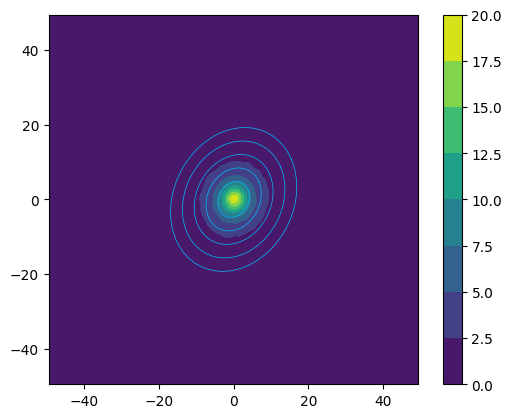

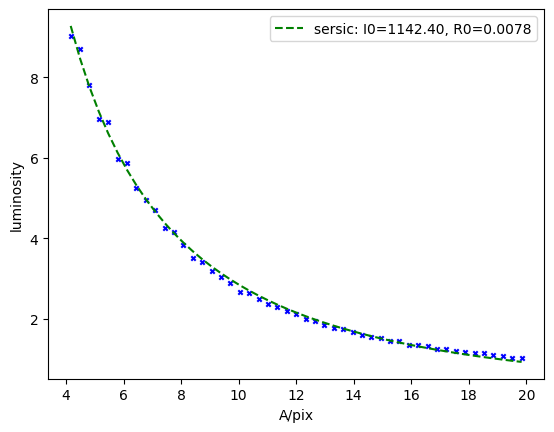

In [22]:
## correct fit
ecc = np.mean(ecc_list)
alpha = np.mean(alpha_list)
A_axis = np.linspace(5,20,5)

x_line = np.linspace(-20,20,100)
y_line = x_line*np.tan(np.pi/2-alpha)

print(fitdata_cut.shape)
X_axis = np.array(range(fitdata_cut.shape[0]))
Y_axis = np.array(range(fitdata_cut.shape[1]))
X_axis = X_axis-np.mean(X_axis)
Y_axis = Y_axis-np.mean(Y_axis)
X_grid,Y_grid = np.meshgrid(X_axis,Y_axis)

fig,ax = plt.subplots()
# ax.plot(x_line,y_line)
for A in A_axis:
    eft.draw_ellipse(ax, center=[0,0], A=A, e=ecc, alpha=np.pi/2-alpha)
axc = ax.contourf(X_grid, Y_grid, fitdata_cut)
ax.axis("scaled")
fig.colorbar(axc)
plt.savefig("test_ellipse_profile.pdf")

# fit sersic
X_rotate_grid = X_grid*np.cos(np.pi/2-alpha)+Y_grid*np.sin(np.pi/2-alpha)
Y_rotate_grid = -X_grid*np.sin(np.pi/2-alpha)+Y_grid*np.cos(np.pi/2-alpha)
A_grid = np.sqrt(X_rotate_grid**2+Y_rotate_grid**2/(1-ecc**2))

A_list = np.linspace(4,20,50)
A_center_list = []
I_list = []
for A_index in range(len(A_list)-1):
    x_samples, y_samples = eft.get_contour_index(A_list[A_index], A_list[A_index+1], A_grid)
    I_value_list = []
    value_check_list = []
    for index in range(len(x_samples)):
        I_value_list.append(fitdata_cut[x_samples[index]][y_samples[index]])
        value_check_list.append(A_grid[x_samples[index]][y_samples[index]])
    if len(I_value_list)==0:
        continue
    I_list.append(np.mean(I_value_list))
    A_center_list.append((A_list[A_index]+A_list[A_index+1])/2)


p0 = [1, 1]
Para = leastsq(eft.err_sersic, p0, args=(A_center_list,I_list))
I0, R0 = Para[0]

print("sersic fitting: I0=%.2f, R0=%.4f"%(I0, R0))

fit_lumi = eft.sersic(Para[0],np.array(A_center_list))

plt.figure()
plt.scatter(A_center_list,I_list,s=10,marker="x",c="blue")
plt.plot(A_center_list,fit_lumi,ls="--",label="sersic: I0=%.2f, R0=%.4f"%(I0, R0),c="g")
plt.xlabel("A/pix")
plt.ylabel("luminosity")
plt.legend()
plt.show()
# plt.savefig("test_fit_sersic.pdf")

## 需要进一步考虑的问题

目前我能想到的存在的问题

* 需要把所有5个band全跑一遍（需要细调参数，还是有一定工作量的）
* 有没有更好的椭圆拟合算法？或者用不同的拟合算法分别做一遍对比一下最终结果。
* 如何精确的找到星系的中心？（上面我是用肉眼调的，需要一个更好的方法
* 在获得L-A关系的时候，如何更好的找到每个bin里L对应的A？简单地找个中心值是不是太简单？
* （重要）怎么做误差分析（我太菜了不会做
* ……

想到什么了之后再加。-----------------------------------By LRayleighJ 230401 12:04